<a href="https://colab.research.google.com/github/ApollineFo/NLP---Hate-Speech/blob/main/hate_speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#calling important libraries
import pandas as pd #for data manipulation
import numpy as np #for data manipulation
import matplotlib as plt #for plotting
import os #for ease of python system interaction
import sys
import re
import nltk
nltk.download("stopwords")
import pickle
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
#retrieving the data
url = "https://raw.githubusercontent.com/ApollineFo/NPL/main/data/labeled_data.csv"

data = pd.read_csv(url)
#checking the dataset features
data.keys()

#removing offensive tweets
data = data[data["class"] !=1]
data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
40,40,3,0,1,2,2,""" momma said no pussy cats inside my doghouse """
63,63,3,0,0,3,2,"""@Addicted2Guys: -SimplyAddictedToGuys http://..."
66,66,3,0,1,2,2,"""@AllAboutManFeet: http://t.co/3gzUpfuMev"" woo..."
67,67,3,0,1,2,2,"""@Allyhaaaaa: Lemmie eat a Oreo &amp; do these..."


In [3]:
#extracting only tweets as features
features = data.iloc[:,6].values
#extracting labels
classes = data.iloc[:,5].values

In [4]:
#preprocessing tweets
processed_features = []

for sentence in range(0, len(features)):
    #Removing special characters
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))
    #removing single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)
    #Removing single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 
    #Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)
    #Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)
    #Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)

In [5]:
#specifying parameters
parameters = [
    {
    'vect__max_df': (0.9,), #ignore terms with frequency higher than aforementioned
        'vect__min_df': (2,), #ignore lower frequencies than aforementioned
        'vect__ngram_range': ((1, 2),), #only unigrams
        'clf__estimator__kernel': ['rbf'], #gausian kernel
    'clf__estimator__gamma': [1e0,], #a gamma of zero
        'clf__estimator__C': [1,],
        'clf__estimator__class_weight': [None, "balanced"] #balanced weight
    },
    {
        'vect__max_df': (0.9,),
        'vect__min_df': (2,),
        'vect__ngram_range': ((1, 2),),
        'clf__estimator__kernel': ['linear'], #linear kernel
    'clf__estimator__C': [1,]
    }
]

In [6]:
# building a pipeline
pipeline = Pipeline([('vect', TfidfVectorizer(parameters)),                     
    ('clf', OneVsRestClassifier(SVC(probability=True))),
])

In [7]:
#splitting the dataset to trian and test set
#80 percent of data for training, 20 percent for testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(processed_features, classes, test_size=0.2, random_state=42)

In [8]:
#grid search
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

In [9]:
#fitting the classifier
classifier = grid_search.fit(X_train, y_train)

#predicting
y_predict = classifier.predict(X_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.8min finished


In [10]:
#confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_predict))
print(classification_report(y_test, y_predict))

[[222  65]
 [ 16 816]]
              precision    recall  f1-score   support

           0       0.93      0.77      0.85       287
           2       0.93      0.98      0.95       832

    accuracy                           0.93      1119
   macro avg       0.93      0.88      0.90      1119
weighted avg       0.93      0.93      0.93      1119



In [11]:
#evaluating the model with ROC AUC score
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_predict, multi_class="ovr")

#with a higher score than 0.5, signifies that our model is useful.

0.8771441972661485

In [12]:
#evaluating the model using cross validation
from sklearn.model_selection import cross_val_score
all_accuracies = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=5)

#returning accuracies of the folds
print(all_accuracies)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.1min finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.1min finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.2min finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.1min finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.2min finished


[0.92625698 0.92849162 0.9273743  0.93072626 0.9261745 ]


In [13]:
#printing standard deviation of accuracies
print(all_accuracies.std())

#earning a low variance meaning; a good indicator that the model will perform similar on all test sets and the prediction obtained is not by chance

0.0016879328960567243


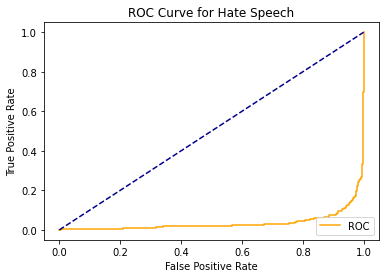

In [60]:
#visually evaluating the model
#function to plot ROC curve
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Hate Speech')
    plt.legend(loc = 'lower right')
    plt.show()

from sklearn.metrics import roc_curve
#calculating the false and true positive rates for all thresholds of the classification
probs = classifier.predict_proba(X_test)[::,1]
#computing auc score
auc = roc_auc_score(y_test, probs)
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label=0)

#plotting the curve
plot_roc_curve(fpr, tpr)